# 4. Lingusitic And Keyword Processing

This file provides functions to display and show linguistic features from the IMDB dataset.

It operates on three sets of linguistic features: movie keywords ('keywords') from the tmdb dataset, plot keywords ('plot_keywords') from the imdb dataset, and keywords extracted from the movie overviews provided by IMDB.

We generate two sets of models. The first set acts on the IMDB/TMDB keywords, of which we use just 'keywords', just 'plot_keywords', and their combination ('all_keywords' = 'keywords' + 'plot_keywords'). Given the set of co-associations between keywords, we learn an embedding for each keyword implemented in Word2Vec. However, keyword order does not matter here, so we use a window high enough to capture all keywords. The model is equivalent to a bag-of-words embedding based on keywords and strictly captures co-occurences, not order.

The second set of models uses pre-trained GloVE embeddings (Pennington et al 2014), https://nlp.stanford.edu/projects/glove/. We match the IMDB/TMDB keywords with theit GloVE embegggings and plot them below. This seems to give the best separablity between movies. Finally, we use movie overview data included in IMDB. The text data is normalized and lemmatized, and these extracted keywords are analyzed with GloVe embeddings. We match text from the overviews with the GloVE embeddings. The movie overview data is a bit messy and more work needs to be done (starting with tf-idf) to mine better keywords from this dataset.

In the model training unit (Main.ipynb) we genereate features from these models by compressing the embeddings for each movie to several domensions using PCA, and use these embeddings for model training.

We conclude that using the IMDB/TMDB keywords with GLoVE word vectors appears to bring best separability between movies. The reader is encouraged to try their own movies and see how the keywords separate.

In [5]:
# %matplotlib inline  
# import gensim.downloader as api
# #Note: Takes ~1 min to download and loaa 128MB word embeddings from the internet.
# word_vectors = api.load("glove-wiki-gigaword-100")
# word_vectors.save(data_path + "glove-wiki-gigaword-100.model")

Please uncomment and run the first line aove if you have not already downloaded the glove language model. Requires internet access.

In [76]:
%matplotlib inline  

#may ignore if already downloaded
import nltk
nltk.download('stopwords')

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from word_utils import *
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from matplotlib import pyplot
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhengyuanma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [118]:
data_path = "data/"
m = pd.read_csv(data_path + "movies_postprocessing.csv")
entities = {}
for col in ["genres", "keywords","plot_keywords","all_keywords" ,"production_companies", "production_countries", "spoken_languages"]:
    m[col] = pd.Series(ast.literal_eval(b) for b in m[col])
genres = ['Mystery', 'Romance', 'History', 'Family', 'Science Fiction', 'Horror', 'Crime', 'Drama', 'Fantasy', 'Animation', 'Music', 'Adventure', 'Foreign', 'Action', 'TV Movie', 'Comedy', 'Documentary', 'War', 'Thriller', 'Western']
m = m.set_index("original_title")
max_num_keywords= 60

In [85]:
def safe_get_word_vector(model, word):
    if word not in model.wv.vocab:
        return [0]* model.vector_size
    return model[word]


#Note: Not used in this file.
def get_tfidf_document_embeddings(docs, model, prefix, no_below=5, no_above=0.2, reduce_dim=100):
    """
    Makes document embeddings based on the tf-idf weighted word embedding framework
    from a word embedding model (either downloaded or trained), and a set of documents. 
    Tf-idf values are computed from the documents and 
    """
    docs = m_exp.keywords
    docs_dict = Dictionary(docs)
    docs_dict.filter_extremes(no_below=no_below, no_above=no_above)
    docs_dict.compactify()

    docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]
    model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
    docs_tfidf  = model_tfidf[docs_corpus]

    #Generage matrix of rows (movie overviews) to columns (tfidf terms)
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

    tfidf_emb_vecs = np.vstack([safe_get_word_vector(model, docs_dict[i]) 
                                for i in range(len(docs_dict))])

    docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 
    
    reduce_dim = min(model.vector_size, reduce_dim)
    pca = PCA(n_components=reduce_dim)
    docs_emb = pca.fit_transform(docs_emb)
    print(col+": Explained variance: ", pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))

    cols = [prefix+"_WV_"+str(i) for i in range(reduce_dim)]
    docs_emb = pd.DataFrame(docs_emb, columns= cols)
    return docs_emb


In [87]:
def get_most_common_with_counts(key, count=1000000, df = m):
    """Universal Helper function.
    Get most common of any List-Categorical variable (that occurs as a Series of List)
    as a sorted list of (id, count) tuples.
    """
    most_common_keywords = sorted(Counter([a for b in df[key] for a in b]).items(), key = lambda kv: kv[1], reverse=True)
    return most_common_keywords[:count]
    
#Get most common of any List-Categorical variable that occurs as a Series of List as a list
def get_most_common(key, count, df = m):
    """Universal Helper function.
    Get most common n of any List-Categorical variable (that occurs as a Series of List) as a list
    """
    most_common_keywords = sorted(Counter([a for b in df[key] for a in b]).items(), key = lambda kv: kv[1], reverse=True)
    most_common_keywords = most_common_keywords[:count]
    most_common_keywords = [a for a,b in most_common_keywords]
    return most_common_keywords

In [185]:
def get_kw_from_series(film_series_name, series_col):
    """Helper function for plot_different_series.
    Gets keywords given a film series, by checking for all films
    with a certain substring in its name."""
    return list(set([a for b in series_col[series_col.index.str.contains(film_series_name)] for a in b]))


def get_kw_for_name(film_series_name, col = "keywords"):
    """Helper function for plot_different_series.
    Gets keywords given a film series, by checking for all films
    with a certain substring in its name."""
    if col not in ["plot_keywords","keywords","all_keywords"]:
        raise ValueError("Need to enter 'plot_keywords','keywords',or 'all_keywords'")
    return get_kw_from_series(film_series_name, m[col])


def get_representation(word_to_ind, result, word):
    """Helper function for plot_different_series."""
    if word not in word_to_ind.keys(): return None
    return result[word_to_ind[word]]

def get_distict(l, to_remove):
    """Helper function for plot_different_series"""
    return [w for w in l if w not in to_remove]

def plot_different_series(ser_list, model, col = "keywords", twodmodel = None, kw_series=None):    
    """
    Given any list of names as List[str] and a keyword-embedding model,
    searches for all films that contain the name as a substring, 
    obtains keywords from the embedding model that are unique to each series in the list,
    and plots the 2d representations of these keywords in the embedding space using PCA.
    
    Intended for plotting comparative keywords relevant to different film series.
    
    @param col: 'keywords', 'plot_keywords', 'all_keywords', or 'overview'.
                If 'overview', series of keywords in Series[List[str]] format
                indexed by movie title must be passed in kw_series
    @param twodmodel: if the 2d reduced embedding is computed beforehand, it may be passed into the
    model to save on recomputing it.
    @param kw_series: must not not None if
    
    """
    result = twodmodel
    if twodmodel is None:
        X = model[model.wv.vocab]
        pca = PCA(n_components=2)
        result = pca.fit_transform(X)
    if col in ['keywords', 'plot_keywords', 'all_keywords']:
        all_kw = [get_kw_for_name(a, col =col) for a in ser_list]
    elif col == "overview":
        if not isinstance(kw_series, pd.Series):
            raise ValueError("Need kw_series")
        all_kw = [get_kw_from_series(a,kw_series) for a in ser_list]
    
    all_list = Counter([a for b in all_kw for a in b])
    to_remove = [a for a, cnt in all_list.items() if cnt != 1]
    all_kw = [get_distict(a, to_remove) for a in all_kw]
    all_kw = dict(zip(ser_list, all_kw))

    fig, ax = plt.subplots(figsize=(10, 10))
    for k, kws in all_kw.items():
        word_to_ind = {w:i for i,w in enumerate(model.wv.vocab)}
        coords = {w:get_representation(word_to_ind, result, w) for w in kws}
        coords = {w:v for w,v in coords.items() if v is not None}
        xs = [a[0] for a in coords.values()]
        ys = [a[1] for a in coords.values()]

        ax.plot(xs, ys, marker='o', linestyle='', 
                ms=8, alpha=0.3, label=k)
        for w,xy in coords.items():
            ax.annotate(w, xy=xy)
    ax.legend()
    plt.show()

### Language (correlation) model using keywords

### From keywords

In [120]:
docs_ = m_exp.keywords
keywords_model = Word2Vec(docs_, size=200, min_count=3, workers=5, window=max_num_keywords)
X = keywords_model[keywords_model.wv.vocab]
pca = PCA(n_components=2)
keywords_2d = pca.fit_transform(X)

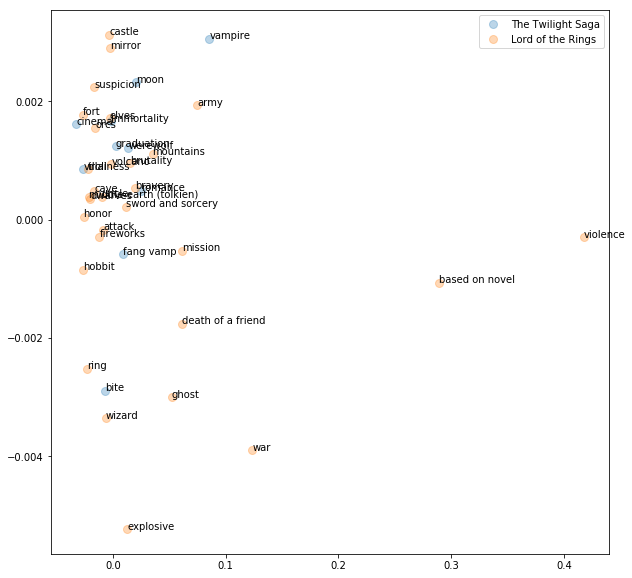

In [137]:
ser_list = ["Lord of the Rings", "The Twilight Saga"]
plot_different_series(ser_list, keywords_model, "keywords", twodmodel=keywords_2d)

#### From Plot_Keywords

In [93]:
docs_ = m_exp.plot_keywords
plot_keywords_model = Word2Vec(docs_, size=200, min_count=3, workers=5, window=max_num_keywords)
X = plot_keywords_model[plot_keywords_model.wv.vocab]
pca = PCA(n_components=2)
plot_keywords_2d = pca.fit_transform(X)

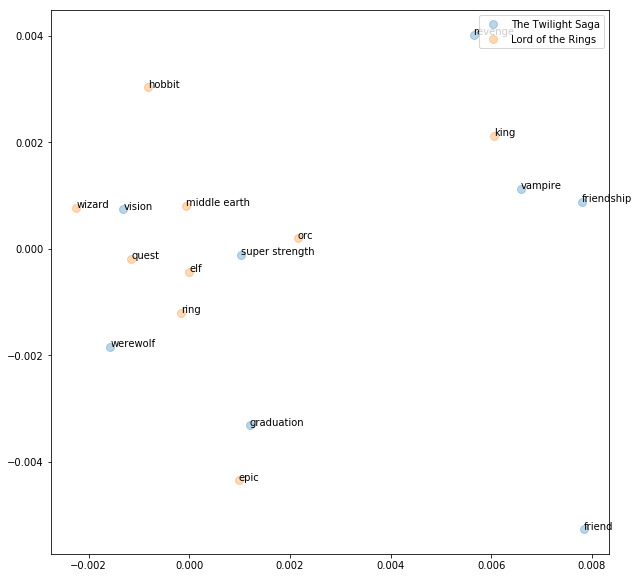

In [138]:
ser_list = ["Lord of the Rings", "The Twilight Saga"]
plot_different_series(ser_list, plot_keywords_model, "plot_keywords", twodmodel=plot_keywords_2d)

#### From a combination of keywords and plot_keywods

In [97]:
docs_ = m_exp.all_keywords
all_keywords_model = Word2Vec(docs_, size=200, min_count=3, workers=5, window=max_num_keywords)
X = all_keywords_model[all_keywords_model.wv.vocab]
pca = PCA(n_components=2)
all_keywords_2d = pca.fit_transform(X)

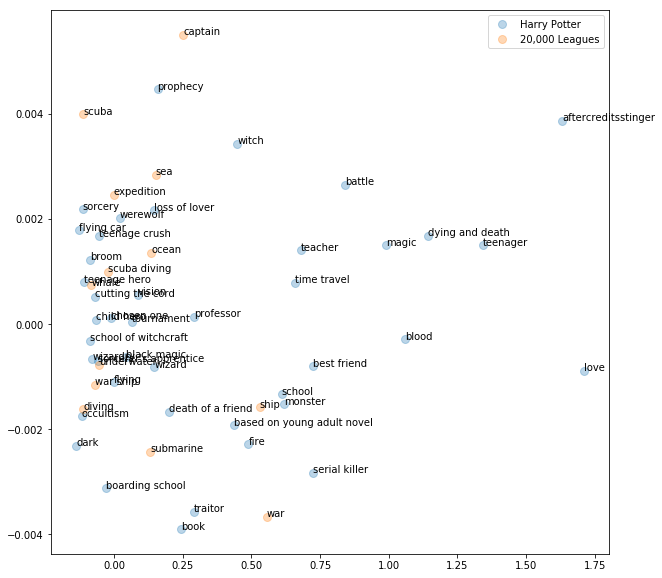

In [139]:
ser_list = ["Harry Potter", "20,000 Leagues"]
plot_different_series(ser_list, all_keywords_model, "all_keywords", twodmodel=all_keywords_2d)

#### From Overviews

In [100]:
#Lemmatization and NLP preprocessing takes a bit of time (~1-2 mins)
normalized_overviews = m.overview.apply(lambda x: lemmatize_verbs(normalize(nltk.word_tokenize(x.decode('utf-8')))))

In [186]:
docs_ = normalized_overviews
overview_model = Word2Vec(docs_, size=200, min_count=5, workers=5, window=5)
X = overview_model[overview_model.wv.vocab]
pca = PCA(n_components=2)
overview_2d = pca.fit_transform(X)

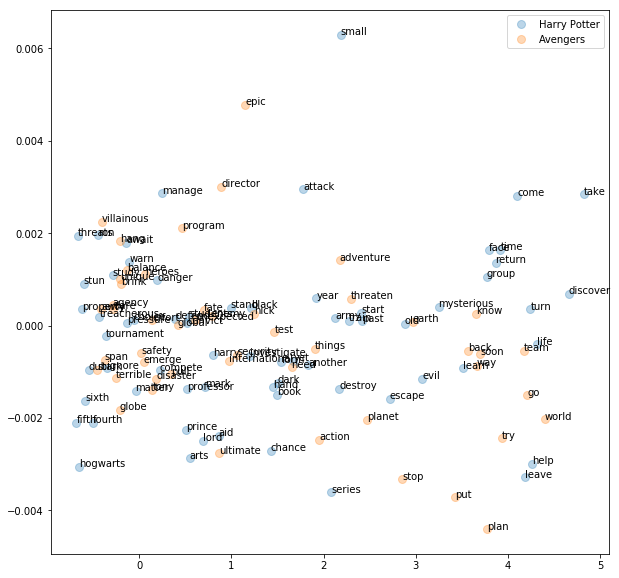

In [187]:
ser_list = ["Harry Potter", "Avengers"]
plot_different_series(ser_list, overview_model, "overview", overview_2d, normalized_overviews)

### Model Using GloVe Vectors

In [22]:
word_vectors = KeyedVectors.load(data_path + "glove-wiki-gigaword-100.model")

In [122]:
X = word_vectors[word_vectors.wv.vocab]
pca = PCA(n_components=2)
glove_2d = pca.fit_transform(X)

#### Using Extracted Data from Overviews and Glove Vectors

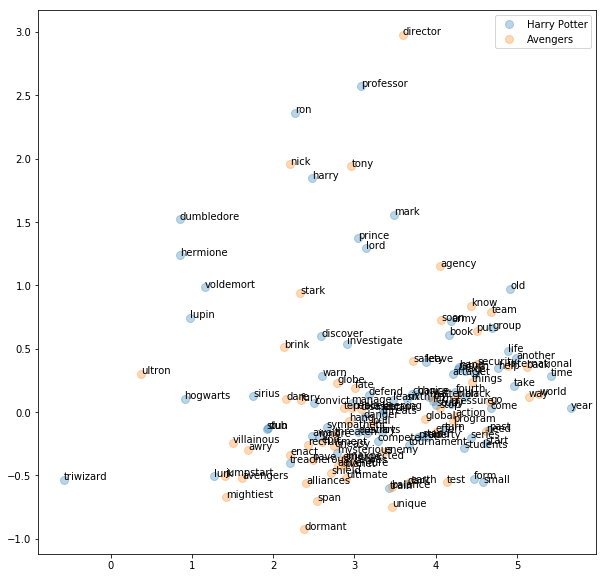

In [140]:
ser_list = ["Harry Potter", "Avengers"]
plot_different_series(ser_list, word_vectors_copy, "overview", glove_2d, normalized_overviews)

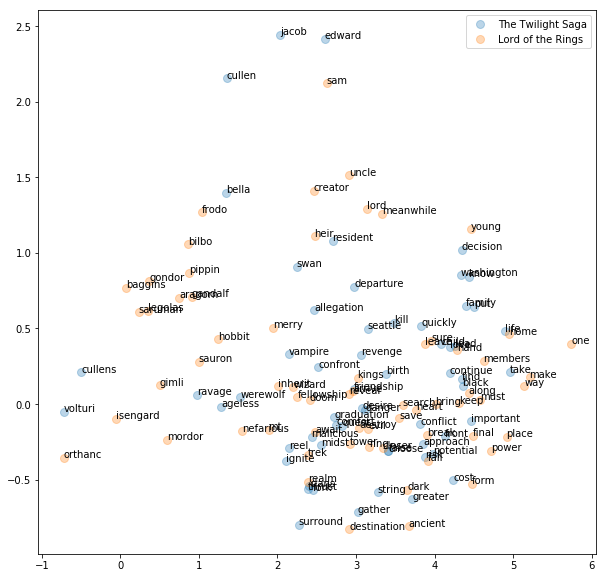

In [141]:
ser_list = ["Lord of the Rings", "The Twilight Saga"]
plot_different_series(ser_list, word_vectors_copy, "overview", glove_2d, normalized_overviews)

### Using IMDB/TMDB Keywords and Glove Vectors

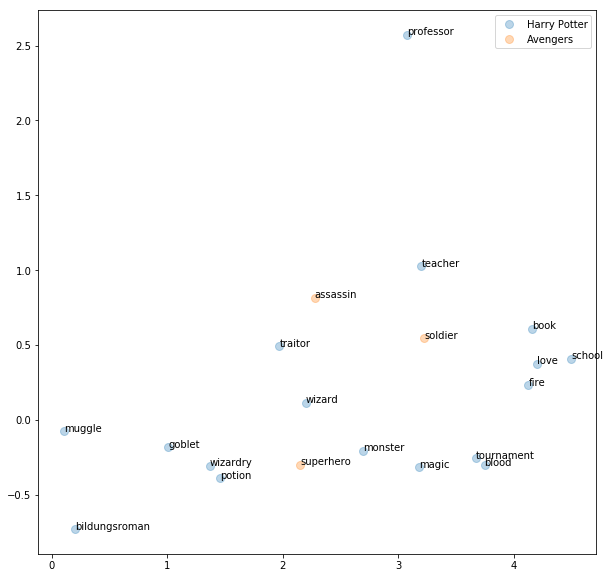

In [143]:
ser_list = ["Harry Potter", "Avengers"]
plot_different_series(ser_list, word_vectors_copy, "plot_keywords", glove_2d)

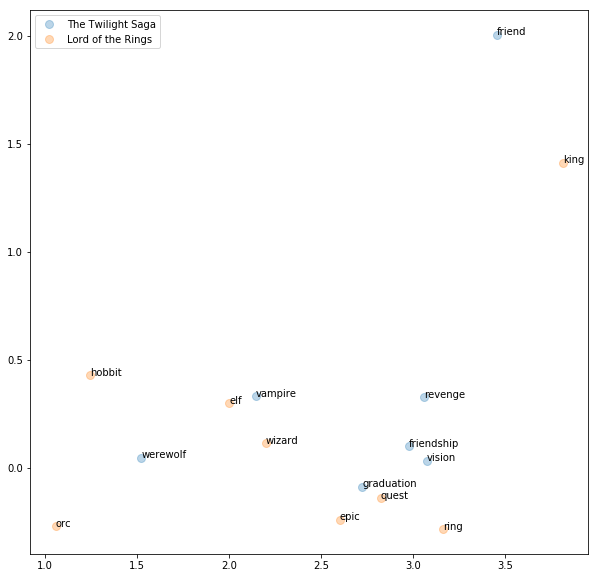

In [144]:
ser_list = ["Lord of the Rings", "The Twilight Saga"]
plot_different_series(ser_list, word_vectors_copy, "plot_keywords", glove_2d)